# 1. Grouped Bar Chart

In [ ]:
df_evaluation_results = pd.read_csv("results/evaluation_results.csv")


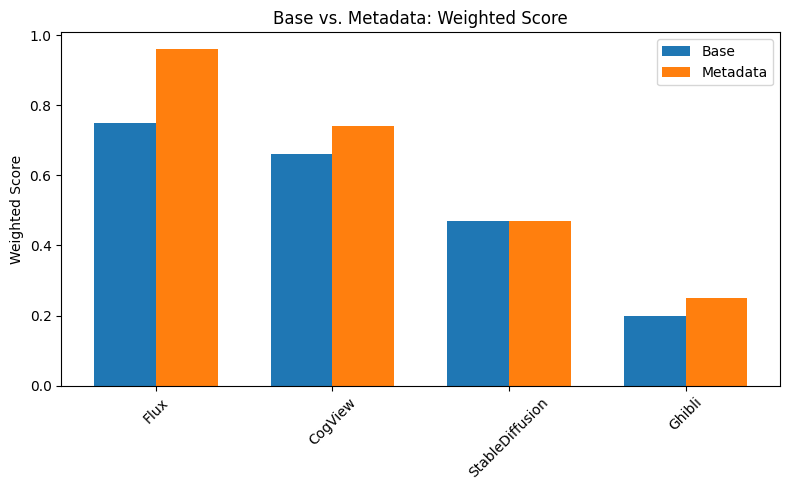

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppose df is your DataFrame read from "evaluation_results.csv"
df = pd.read_csv("results/evaluation_results.csv")

# 1) Separate base models (no "_Metadata") and metadata models
df_base = df[~df["Model"].str.endswith("_Metadata")].copy()
df_meta = df[df["Model"].str.endswith("_Metadata")].copy()

# 2) Extract a short "base name" so e.g. "Flux_Metadata" becomes "Flux"
df_base["BaseName"] = df_base["Model"]
df_meta["BaseName"] = df_meta["Model"].str.replace("_Metadata", "")

# 3) Merge metadata row into base row to get columns side-by-side
merged = pd.merge(df_base, df_meta, on="BaseName", suffixes=("_base","_meta"))

# 4) Plot grouped bars for Weighted Score
x = np.arange(len(merged))  # e.g. each row is a base
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2,
                merged["Weighted Score ⬆️_base"],
                width, label='Base')
rects2 = ax.bar(x + width/2,
                merged["Weighted Score ⬆️_meta"],
                width, label='Metadata')

ax.set_xticks(x)
ax.set_xticklabels(merged["BaseName"], rotation=45)
ax.set_ylabel("Weighted Score")
ax.set_title("Base vs. Metadata: Weighted Score")
ax.legend()

plt.tight_layout()
plt.show()


# 2. Slope Chart (Model → Metadata)
A slope chart highlights how a single metric changes from one condition (“model”) to another (“model_Metadata”). You connect each base vs. metadata with a line:

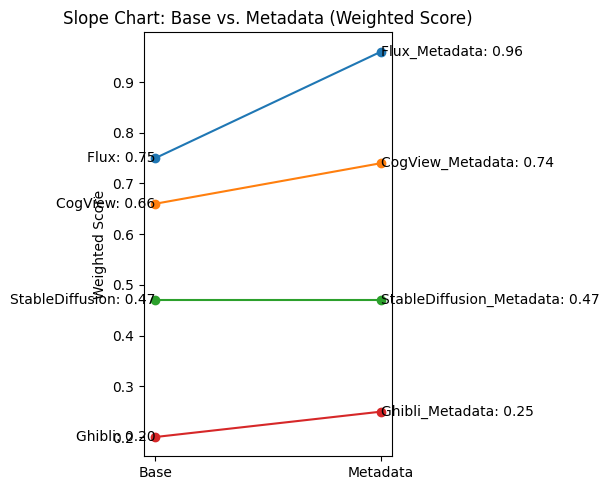

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,5))

for i, row in merged.iterrows():
    x_vals = [0, 1]  # base = x=0, metadata = x=1
    y_vals = [row["Weighted Score ⬆️_base"], row["Weighted Score ⬆️_meta"]]
    
    # Draw line and points
    ax.plot(x_vals, y_vals, marker='o', label=row["BaseName"] if i==0 else "")
    ax.text(0, y_vals[0], f'{row["BaseName"]}: {y_vals[0]:.2f}', va='center', ha='right')
    ax.text(1, y_vals[1], f'{row["BaseName"]}_Metadata: {y_vals[1]:.2f}', va='center', ha='left')

ax.set_xticks([0,1])
ax.set_xticklabels(["Base","Metadata"])
ax.set_ylabel("Weighted Score")
ax.set_title("Slope Chart: Base vs. Metadata (Weighted Score)")
plt.tight_layout()
plt.show()


# 3. Radar (Spider) Chart
-- A radar chart can display multiple metrics at once for each model vs. metadata. For example, you could show the Weighted Score, Avg Clip Cos Sim, LPIPS, etc. for both versions.

-- Below is a small snippet for one base. You would create two polygons: one for the base and one for its metadata. Repeat for each base or combine them:

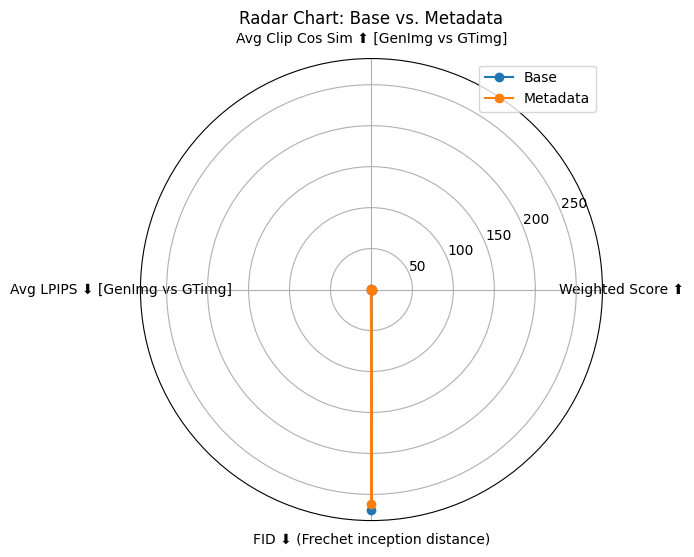

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example for a single base
metrics = ["Weighted Score ⬆️", "Avg Clip Cos Sim ⬆️ [GenImg vs GTimg]", 
           "Avg LPIPS ⬇️ [GenImg vs GTimg]", "FID ⬇️ (Frechet inception distance)"]
N = len(metrics)

base_values = [
    row["Weighted Score ⬆️_base"],
    row["Avg Clip Cos Sim ⬆️ [GenImg vs GTimg]_base"],
    row["Avg LPIPS ⬇️ [GenImg vs GTimg]_base"],
    row["FID ⬇️ (Frechet inception distance)_base"]
]

meta_values = [
    row["Weighted Score ⬆️_meta"],
    row["Avg Clip Cos Sim ⬆️ [GenImg vs GTimg]_meta"],
    row["Avg LPIPS ⬇️ [GenImg vs GTimg]_meta"],
    row["FID ⬇️ (Frechet inception distance)_meta"]
]

angles = np.linspace(0, 2*np.pi, N, endpoint=False)
base_values = np.concatenate((base_values, [base_values[0]]))
meta_values = np.concatenate((meta_values, [meta_values[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, base_values, 'o-', label="Base")
ax.fill(angles, base_values, alpha=0.1)
ax.plot(angles, meta_values, 'o-', label="Metadata")
ax.fill(angles, meta_values, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, rotation=45)
ax.set_title("Radar Chart: Base vs. Metadata")
ax.legend(loc='upper right')
plt.show()


# 4. “Difference” Bar Chart
-- Sometimes you just want to show how much the metadata improved (or got worse) relative to the base. You can compute:

`improvement = metadata_score - base_score`

-- Then plot a single bar for each base:

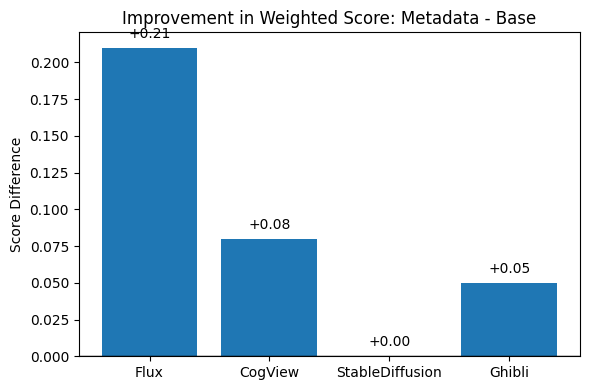

In [6]:
import matplotlib.pyplot as plt

merged["Improvement"] = merged["Weighted Score ⬆️_meta"] - merged["Weighted Score ⬆️_base"]

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(merged["BaseName"], merged["Improvement"])
ax.axhline(0, color='black', linewidth=1)
ax.set_title("Improvement in Weighted Score: Metadata - Base")
ax.set_ylabel("Score Difference")

for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{height:+.2f}", 
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


# 5. Subplots for Multiple Metrics
If you want to quickly see multiple metrics at once (Weighted Score, FID, LPIPS, etc.), you can do subplots:

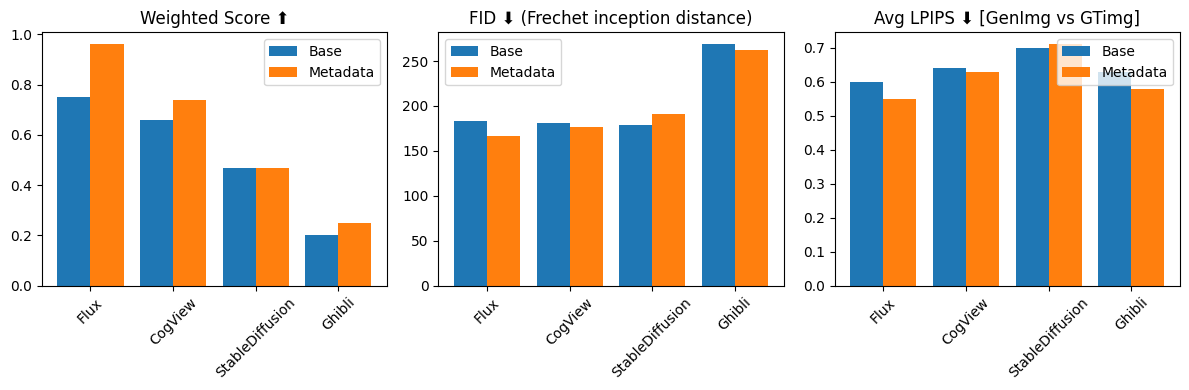

In [7]:
metrics_of_interest = ["Weighted Score ⬆️", 
                       "FID ⬇️ (Frechet inception distance)", 
                       "Avg LPIPS ⬇️ [GenImg vs GTimg]"]

fig, axes = plt.subplots(1, len(metrics_of_interest), figsize=(12,4), sharey=False)

for i, metric in enumerate(metrics_of_interest):
    ax = axes[i]
    
    # Plot bars for base vs metadata side by side
    x = np.arange(len(merged))
    width = 0.4
    ax.bar(x - width/2, merged[f"{metric}_base"], width, label="Base")
    ax.bar(x + width/2, merged[f"{metric}_meta"], width, label="Metadata")
    ax.set_xticks(x)
    ax.set_xticklabels(merged["BaseName"], rotation=45)
    ax.set_title(metric)
    ax.legend()

plt.tight_layout()
plt.show()
